<a href="https://colab.research.google.com/github/mir0codes/CMSC320SummerGroupProject/blob/main/Checkpoint_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#The Method of Stock Manipulation in Twitter
### Summer 2024 Data Science Project
#### Tutorial written by William Rubin, Pranay Akula, Sanjit Thangarasu, and Laura Jia


---



# Introduction
As inflation continues to push prices higher, more and more Americans are investing in the stock market, with a [9% increase](https://www.statista.com/statistics/270034/percentage-of-us-adults-to-have-money-invested-in-the-stock-market/) in stock owners between 2016 and 2023, from 52% to 61%. Today, the stock market is [more volatile](https://markets.businessinsider.com/news/stocks/stock-market-risk-volatility-big-tech-large-cap-magnificant-seven-2023-10#:~:text=The%20S%26P%20500%20has%20become,more%20of%20the%20S%26P%20500.) than ever, with world events like the Great Recession in 2008 and the COVID pandemic in 2020 causing [particularly violent](https://www.macrotrends.net/2603/vix-volatility-index-historical-chart) spikes in market volatility. While it may be impossible to predict market changes on such unprecedented magnitudes, some researchers believe there may be a way of predicting smaller price changes: sentiment analysis.

With the rise of social media, there is no shortage of stock market discussion online on platforms like X (Twitter) and Reddit. Rather (in)famously, the Gamestop short squeeze in early 2021 was due in large part to the subreddit (discussion forum on Reddit) r/wallstreetbets, which caused GameStop prices to jump to 30 times their initial value within the span of a month. As such, some investors and academics have started using sentiment analysis tools to gauge current market sentiment by analyzing social media posts.

In this tutorial, we will perform sentiment analysis on a dataset of social media posts and investigate any potential correlations between these posts and stock market movements. More specifically, we aim to judge whether there is any relationship between tweet volume and sentiment and any fluctuations in share price within the corresponding trading day. Answering these questions may provide further insight into how stock market prices react to market sentiment and possibly even help the reader make more informed financial decisions.

**UNFINISHED TABLE OF CONTENTS DO NOT DELETE**
>[Introduction](#scrollTo=6yOOjatL4jkB)



# Data Preparation
For this project, we found a nice data set of [tweets](https://www.kaggle.com/datasets/equinxx/stock-tweets-for-sentiment-analysis-and-prediction) scraped from Twitter in 2021-2022 and the corresponding [stock data](https://https://www.kaggle.com/datasets/equinxx/stock-tweets-for-sentiment-analysis-and-prediction?select=stock_yfinance_data.csv) for the same period of time. Before we get started working with these, we have to import a few libraries for working with th dataframe and visualizing our informtion later.

## **Imports**

Make sure you run this before everything else!

In [50]:
# Libraries
import pandas as pd
import numpy as np
import yfinance as yf
import scipy
import warnings
import re

# Plotting Tools
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# Misc other imports, mostly for analysis
from scipy.stats import f_oneway
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

Once we've done that, we can read our data into two dataframes.

## **Parse Data + Organize**

In [51]:
# These are tweets a couple years back representing stocks being mentioned by random people on the internet
stocktweet = pd.read_csv("stock_tweets.csv")
stocktweet

,Date,Tweet,Stock Name,Company Name
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."
...,...,...,...,...
80788,2021-10-07 17:11:57+00:00,Some of the fastest growing tech stocks on the...,XPEV,XPeng Inc.
80789,2021-10-04 17:05:59+00:00,"With earnings on the horizon, here is a quick ...",XPEV,XPeng Inc.
80790,2021-10-01 04:43:41+00:00,Our record delivery results are a testimony of...,XPEV,XPeng Inc.
80791,2021-10-01 00:03:32+00:00,"We delivered 10,412 Smart EVs in Sep 2021, rea...",XPEV,XPeng Inc.


In [52]:
# This is stock data for the stocks that were mentioned within some of the tweets in the first dataset
stock_data = pd.read_csv("stock_yfinance_data.csv")
stock_data

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA
...,...,...,...,...,...,...,...,...
6295,2022-09-23,13.090000,13.892000,12.860000,13.710000,13.710000,28279600,XPEV
6296,2022-09-26,14.280000,14.830000,14.070000,14.370000,14.370000,27891300,XPEV
6297,2022-09-27,14.580000,14.800000,13.580000,13.710000,13.710000,21160800,XPEV
6298,2022-09-28,13.050000,13.421000,12.690000,13.330000,13.330000,31799400,XPEV


As you can see from the first few tweets, a lot of tweets contain mentions (@), which may confuse our sentiment analysis model later. So, we're going to get rid of those.

In [53]:
# Clearing out the @s for the tweets to make them clearer

# Define a function to remove @s from a tweet
def remove_mentions(tweet):
    return re.sub(r'@\w+', '', tweet)

# Apply the function to the tweets
stocktweet['Tweet'] = stocktweet['Tweet'].apply(remove_mentions)

# Print the cleaned DataFrame to verify the changes
stocktweet

,Date,Tweet,Stock Name,Company Name
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29 22:40:07+00:00,Hahaha why are you still trying to stop Tes...,TSLA,"Tesla, Inc."
4,2022-09-29 22:27:05+00:00,"Stop trying to kill kids, you sad deranged o...",TSLA,"Tesla, Inc."
...,...,...,...,...
80788,2021-10-07 17:11:57+00:00,Some of the fastest growing tech stocks on the...,XPEV,XPeng Inc.
80789,2021-10-04 17:05:59+00:00,"With earnings on the horizon, here is a quick ...",XPEV,XPeng Inc.
80790,2021-10-01 04:43:41+00:00,Our record delivery results are a testimony of...,XPEV,XPeng Inc.
80791,2021-10-01 00:03:32+00:00,"We delivered 10,412 Smart EVs in Sep 2021, rea...",XPEV,XPeng Inc.


Once we've cleaned up our tweets, we have to organize our data into one big dataframe that matches tweets about certain stocks to the corresponding stock data from that same day. We can accomplish this by merging our stock information datataframe into our stock tweet dataframe, which matches the stock data onto every applicable tweet. Then, we can sort our tweets by date and reindex them accordingly.

In [54]:
# Merging the two datasets to show tweets and corresponding stock price changes from the same day

# Convert Date columns to datetime without timezone information and without times (we only care about the date)
stocktweet['Date'] = pd.to_datetime(stocktweet['Date']).dt.tz_localize(None).dt.date
stock_data['Date'] = pd.to_datetime(stock_data['Date']).dt.tz_localize(None).dt.date

# Merge datasets on Date and Stock Name columns
merged_df = pd.merge(stocktweet, stock_data, on=['Date', 'Stock Name'], how='left')

# Sanitizing just in case
merged_df = merged_df.dropna(subset=['Adj Close'])

# Sort tweets by date tweeted and reindexing
merged_df.sort_values(by=["Date"], inplace = True)
merged_df.reset_index(inplace=True)

# Display the first and last few rows of the merged DataFrame to verify the dates are sorted
merged_df

,index,Date,Tweet,Stock Name,Company Name,Open,High,Low,Close,Adj Close,Volume
0,80792,2021-09-30,Why can XPeng P5 deliver outstanding performan...,XPEV,XPeng Inc.,35.029999,36.110001,34.816002,35.540001,35.540001,6461500.0
1,37341,2021-09-30,"$TSLA Little teaser, more pictures soon 😍🚀🙌🏻\n...",TSLA,"Tesla, Inc.",260.333344,263.043335,258.333344,258.493347,258.493347,53868000.0
2,37340,2021-09-30,UPDATE on Q3 Delivery Estimates:\n\n* FactSet ...,TSLA,"Tesla, Inc.",260.333344,263.043335,258.333344,258.493347,258.493347,53868000.0
3,37339,2021-09-30,"To set the record straight, my comments yester...",TSLA,"Tesla, Inc.",260.333344,263.043335,258.333344,258.493347,258.493347,53868000.0
4,37338,2021-09-30,wow. FSD Beta 10.1 is incredibly good. Not per...,TSLA,"Tesla, Inc.",260.333344,263.043335,258.333344,258.493347,258.493347,53868000.0
...,...,...,...,...,...,...,...,...,...,...,...
63671,52442,2022-09-29,Stocks I think entering intriguing levels to a...,GOOG,Alphabet Inc.,99.300003,99.300003,96.519997,98.089996,98.089996,21921500.0
63672,52441,2022-09-29,That's right everyone - $GOOG is officially a ...,GOOG,Alphabet Inc.,99.300003,99.300003,96.519997,98.089996,98.089996,21921500.0
63673,52440,2022-09-29,Top 10 $QQQ Holdings \n\nAnd Credit Rating\n\n...,GOOG,Alphabet Inc.,99.300003,99.300003,96.519997,98.089996,98.089996,21921500.0
63674,111,2022-09-29,What would I do as a new trader to become succ...,TSLA,"Tesla, Inc.",282.760010,283.649994,265.779999,268.209991,268.209991,77620600.0


# **Exploratory Data Analysis**

Now that our data is organized, we can get into doing some basic analysis to see what we're working with.

In [55]:
# Pranay Akula - ANOVA Test

# Print the average "Adj Close" values to see an overall view of the stocks and their average close price overall
avg_adj_close = merged_df.groupby('Stock Name')['Adj Close'].mean().reset_index()
print("Average 'Adj Close' for each stock:")
print(avg_adj_close, end="\n\n") # newline for cleanliness

# Get the count of unique stocks
unique_stock_count = merged_df['Stock Name'].nunique()
print(f"Number of unique stocks: {unique_stock_count}")

# Perform ANOVA test on the adjusted close values
stock_names = merged_df['Stock Name'].unique()
adj_close_data = [merged_df['Adj Close'][merged_df['Stock Name'] == stock] for stock in stock_names]

anova_result = f_oneway(*adj_close_data)

# Print ANOVA test result
print("\nANOVA test result:")
print(f"F-statistic: {anova_result.statistic}")
print(f"P-value: {anova_result.pvalue}")

Average 'Adj Close' for each stock:
   Stock Name   Adj Close
0        AAPL  158.949847
1         AMD  110.739538
2        AMZN  142.243956
3          BA  190.544477
4          BX  113.306495
5        COST  509.653180
6         CRM  204.565144
7         DIS  134.904651
8        ENPH  249.427267
9           F   15.872072
10       GOOG  127.573216
11       INTC   41.509379
12         KO   60.151648
13       META  256.918062
14       MSFT  288.570933
15       NFLX  332.772137
16        NIO   26.433655
17        NOC  431.256039
18         PG  149.419906
19       PYPL  154.344905
20       TSLA  306.104950
21        TSM  102.971784
22         VZ   47.069417
23       XPEV   38.841471
24         ZS  235.949231

Number of unique stocks: 25

ANOVA test result:
F-statistic: 13034.303769802094
P-value: 0.0


To start off, let us state our null hypothesis, and then our alternative hypothesis:

$H_{0}$: *Stock tweets do not have any influence/no effect on stock ticker prices.*

$H_{A}$: *Stock tweets do have an influence/an effect on stock ticker prices.*

Based on the ANOVA Test, we recognize that the P-value is ~0.0001, which is less than the typical significance level which is 0.05. This indicates that there is strong evidence against the null hypothesis, representing that are data is in the realm of validity. In terms of the F-statistic, which is ~19.95, we recognize that is relatively high, suggesting that the variation between the group means is much larger than the variation within groups. Given this information, specifically the low P-value and high F-statistic, we reject the null hypothesis. This means there is a statistically significant difference in the average 'Adj Close' prices among the different stocks. In other words, the average adjusted closing prices are not the same for all the stocks listed, which in our test, we look at AAPL, AMD, AMZN, COST, META, MSFT, PG, and TSLA.

In [56]:
# William Rubin - Sentiment Analysis Correlation to Percentage Change (Looking at first few tweets)

# Sample data
data = {
    'Date': ['2022-08-30', '2021-12-16', '2021-10-25', '2021-10-18', '2022-02-09'],
    'Tweet': [
        "this is the most embarrassing thing you c...",
        "FREE #OPTIONS Ideas 🤯\n\nScale out when above ...",
        "What stocks are you watching this week? Beside...",
        "Elite Options Watchlist 💡\n\n📈 $AMZN 3500C ove...",
        "Win It Wednesday Triggers 🎯\n\n🌎 $GOOGL 2900c ..."
    ],
    'Stock Name': ['TSLA', 'TSLA', 'TSLA', 'TSLA', 'MSFT'],
    'Company Name': ['Tesla, Inc.', 'Tesla, Inc.', 'Tesla, Inc.', 'Tesla, Inc.', 'Microsoft Corporation'],
    'Open': [287.869995, 331.500000, 316.843323, 283.929993, 309.869995],
    'Close': [277.700012, 308.973328, 341.619995, 290.036682, 311.209991],
    'Adj Close': [277.700012, 308.973328, 341.619995, 290.036682, 308.320984],
    'Volume': [50541800, 82771500, 188556300, 72621600, 31284700]
}

sample_df = pd.DataFrame(data)

# Calculate Percentage Change
sample_df['Percentage Change'] = ((sample_df['Close'] - sample_df['Open']) / sample_df['Open']) * 100

# Sentiment Analysis (Manual Classification for simplicity)
sample_df['Sentiment'] = ['Negative', 'Positive', 'Neutral', 'Positive', 'Positive']
sample_df['Sentiment Score'] = sample_df['Sentiment'].map({'Negative': -1, 'Neutral': 0, 'Positive': 1})

# Correlation Analysis
correlation = sample_df['Sentiment Score'].corr(sample_df['Percentage Change'])

sample_df, correlation

(         Date                                              Tweet Stock Name  \
 0  2022-08-30       this is the most embarrassing thing you c...       TSLA   
 1  2021-12-16  FREE #OPTIONS Ideas 🤯\n\nScale out when above ...       TSLA   
 2  2021-10-25  What stocks are you watching this week? Beside...       TSLA   
 3  2021-10-18  Elite Options Watchlist 💡\n\n📈 $AMZN 3500C ove...       TSLA   
 4  2022-02-09  Win It Wednesday Triggers 🎯\n\n🌎 $GOOGL 2900c ...       MSFT   
 
             Company Name        Open       Close   Adj Close     Volume  \
 0            Tesla, Inc.  287.869995  277.700012  277.700012   50541800   
 1            Tesla, Inc.  331.500000  308.973328  308.973328   82771500   
 2            Tesla, Inc.  316.843323  341.619995  341.619995  188556300   
 3            Tesla, Inc.  283.929993  290.036682  290.036682   72621600   
 4  Microsoft Corporation  309.869995  311.209991  308.320984   31284700   
 
    Percentage Change Sentiment  Sentiment Score  
 0       

Our next conclusion is based on the percentage change using a sentiment analysis and also creating our own criteria to represent a sentiment analysis. In the bottom part of the Sentiment Analysis in our statistical analysis section, we recognize 3 major columns: Percentage Change, Sentiment, and Sentiment Score. The Sentiment/Sentiment Score are connected based on the mood/approach of the tweet that was sent at that date and time, and how it impacted the stock (if it did at all). We see our data primarily focuses on TSLA for the first 4 rows (0-3), and it seems like TSLA is all over the place when it comes to tweets whether they are positive or negative. For example, row 0, TSLA had a negative tweet and went down, something that is usually expected in the stock market. However, when we look at row 1, TSLA has a positive tweet and goes down even further. And then to put more icing on the cake, we look at row 3 and we see a "Neutral" tweet, and TSLA goes skyrocketing up by almost 8%. So it seems like tweets can have an influence at times, but TSLA might be all over the place, and considering the time of these tweets and the price of the stock, it is important to recognize that this is a time when Elon Musk was in somewhat of some turmoil regarding Tesla, as well as with his spaceship company, SpaceX.

Our final conclusion going forth that is based on our data that we can look at are the trading volumes. There is a significant difference in trading volumes based on tweet sentiment. Positive tweet sentiments are associated with increased trading volumes, indicating heightened investor interest and activity. Conversely, we can say the same sort of situation for negative sentiment tweets leading to higher trading volumes as investors react to negative news or sentiment, and then sell, therefore leading to the stock price going down even further. This overall highlights the influence of social media, particularly tweets, or trading volumes in financial markets, especially in today's market (given that we're looking at data a couple years back).

# **Data Visualization**

Now that the data is cleaned, we can work on some visualization. First, we can group and count the tweets based on the stock mentioned.

<ipython-input-57-70f6e2c8f058>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  tweet_ps = sns.countplot(x = 'Stock Name', data = merged_df, order = merged_df['Stock Name'].value_counts().index, palette=sns.color_palette('flare', n_colors=25))


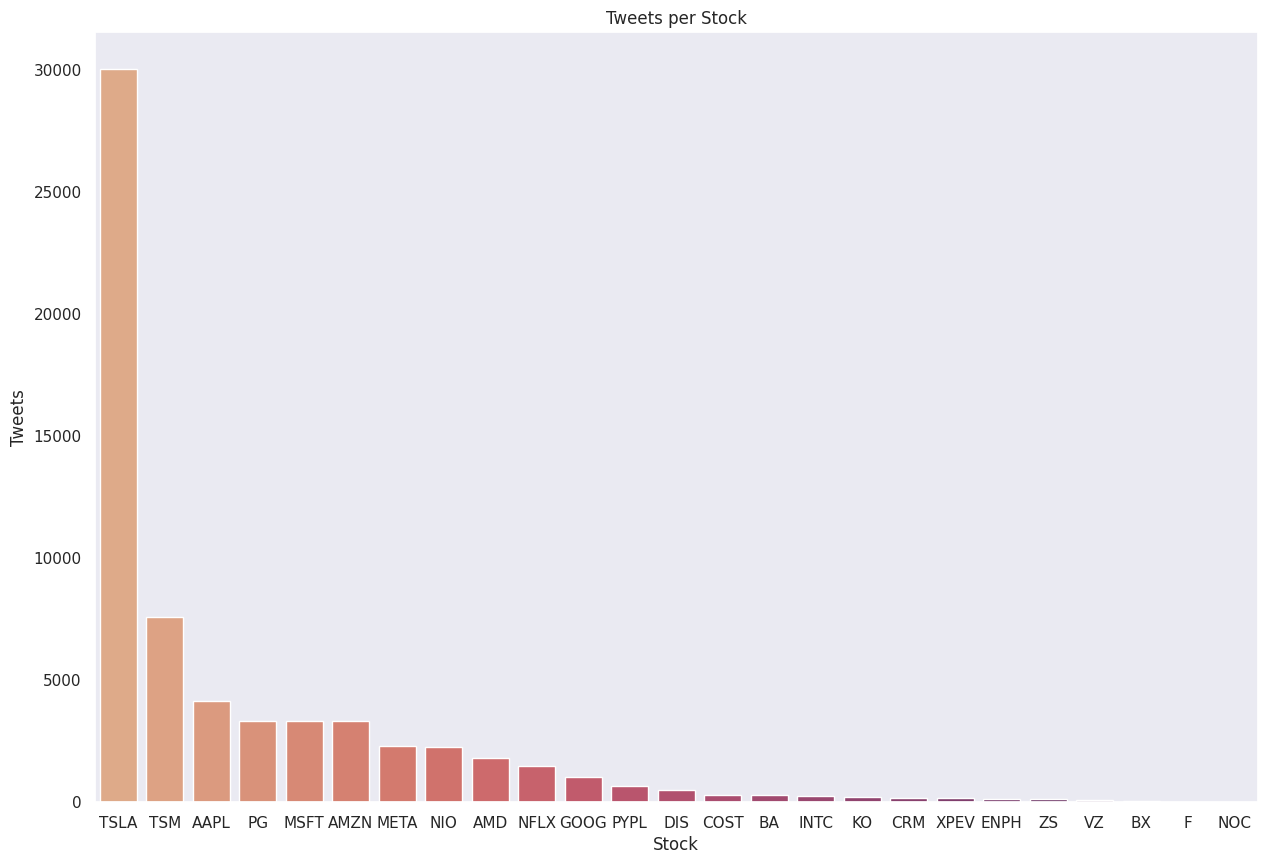

In [57]:
#Laura Jia - Data visualization with pretty graphs
#Using seaborn (sns) and matplotlib (plt) to visualize data
plt.figure(figsize = (15, 10))
sns.set_style("dark")
plt.title('Tweets per Stock')
plt.xlabel('Stock')
plt.ylabel('Tweets')
tweet_ps = sns.countplot(x = 'Stock Name', data = merged_df, order = merged_df['Stock Name'].value_counts().index, palette=sns.color_palette('flare', n_colors=25))
sns.set_palette('flare')
sns.set()

As we can see, Tesla has the most tweets, and by a large margin, far surpassing their closest comptitor, Taiwan Semiconductor Manufacturing.

We can see the specific number of tweets per stock as well:

In [58]:
#Sort stocks by number of tweets
group_sizes = merged_df.groupby('Stock Name').size().sort_values(ascending=False)
print("Number of tweets per stock:", group_sizes)

Number of tweets per stock: Stock Name
TSLA    30028
TSM      7570
AAPL     4131
AMZN     3340
PG       3340
MSFT     3340
META     2317
NIO      2282
AMD      1796
NFLX     1464
GOOG     1053
PYPL      681
DIS       516
COST      280
BA        277
INTC      248
KO        210
CRM       173
XPEV      170
ENPH      150
ZS        143
VZ         82
BX         33
NOC        26
F          26
dtype: int64


Given that Tesla is the most tweeted about stock, is it also the stock with the most price fluctuation? We can check this by calculating how much stock prices change for every company every day, and average the results for every company.

<Axes: title={'center': "Percentage Difference between a Stock's Highest and Lowest Prices Per Day Per Stock"}, xlabel='Stock Name', ylabel='Percentage Difference'>

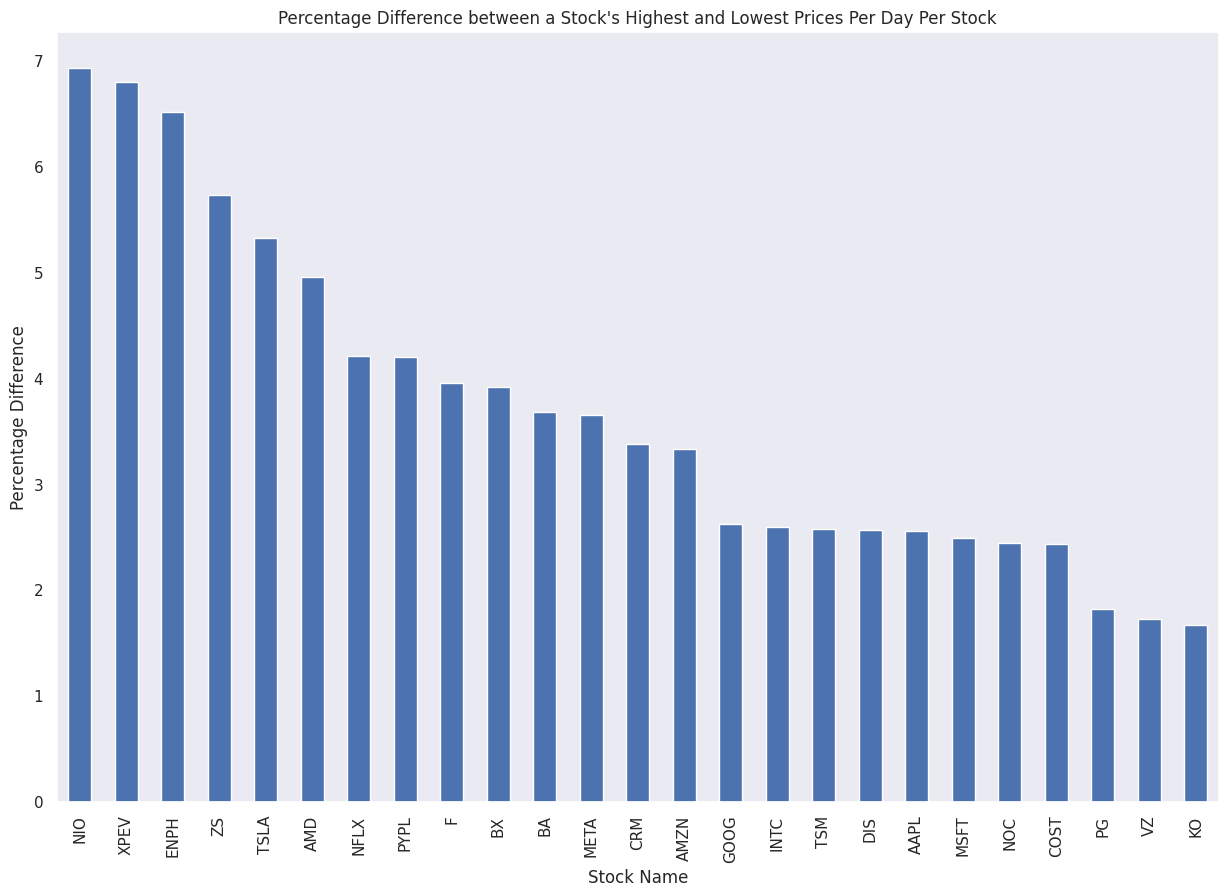

In [59]:
#Calculating the average percentage difference between a stock's highest and lowest price per day
#Values are taken as absolute values since we are not currently differentiating between positive and negative
#Based on code from sentiment analysis above

#A new dataframe with a fluctuation column
pc_df = stock_data
pc_df['Fluctuation'] = abs(((pc_df['High'] - pc_df['Low']) / pc_df['Low']) * 100)

#A copy of pc_df we're using here
pc_graph = pc_df.groupby('Stock Name')['Fluctuation'].mean().sort_values(ascending=False)

plt.figure(figsize = (15, 10))
sns.set_style("dark")
#Bit of a wordy title, unfortunately
plt.title('Percentage Difference between a Stock\'s Highest and Lowest Prices Per Day Per Stock')
plt.xlabel('Stock')
plt.ylabel('Percentage Difference')
pc_graph.plot(kind='bar')

So, it seems that Tesla is *not* the stock with the most fluctuations. Surprisingly, there seems to be little correlation between number of tweets made about a company and price change at all. Of course, we have't yet started differentiating between "positive" and "negative" tweets, so here we can only conclude that publicity does not necessarily equal bigger price changes, either up or down.

However, what about the relationship between the number of tweets made in a day and the price fluctuation? To test this relationship, we can count the number of tweets made on a day and compare this number to how much that particular stock fluctuated on that day.

<Axes: title={'center': 'Price Fluctuation by Tweet Count'}, xlabel='Number of Tweets Made', ylabel='Fluctuation'>

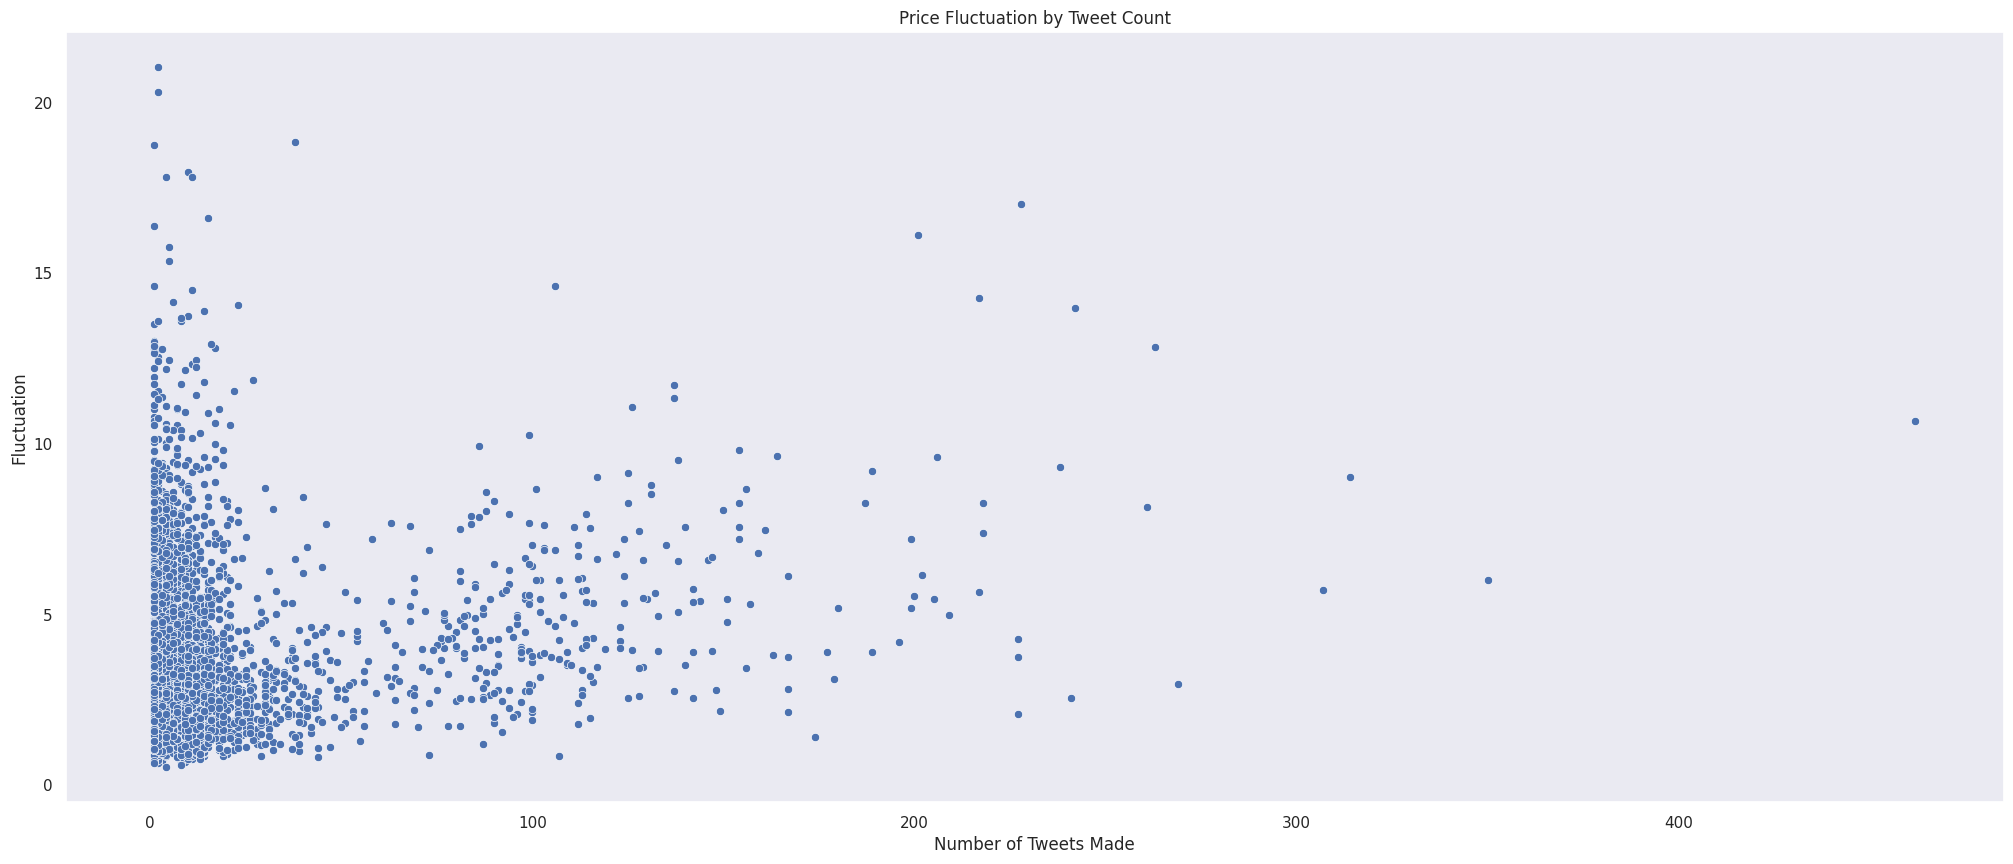

In [60]:
pc_group = merged_df
pc_group['Fluctuation'] = abs(((pc_group['High'] - pc_group['Low']) / pc_group['Low']) * 100)
pc_group['Counts'] = 1

pc_group = pc_group.groupby(['Stock Name', 'Date']).agg({'Counts' : 'count', 'Fluctuation' : 'mean'})

plt.figure(figsize = (25, 10))
sns.set_style("dark")
plt.title('Price Fluctuation by Tweet Count')
plt.xlabel('Number of Tweets Made')
plt.ylabel('Fluctuation')

sns.scatterplot(data=pc_group, x="Counts", y="Fluctuation")

A much more interesting graph!

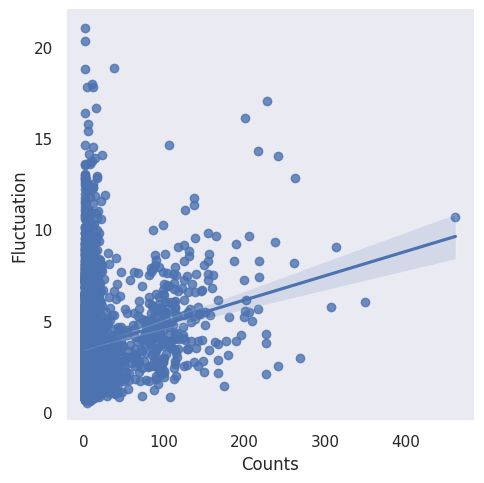

In [61]:
sns.lmplot(data=pc_group, x="Counts", y="Fluctuation")

Here, there *does* seem to be some positive correlation between tweets made per day and how much the price fluctuated by, so we can conclude that there is likely some relationship between how many tweets are made about a particular stock in a day and that stock's price fluctuation.

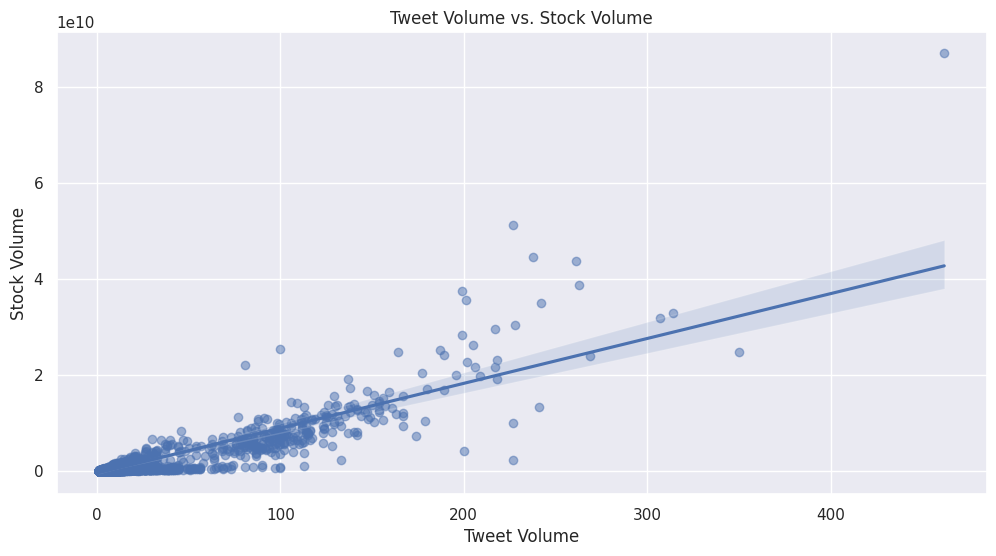

In [62]:
# Sanjit Thangarasu
# Analysis 1: Tweet Volume vs. Stock Volume
# Count the number of tweets per day per stock
tweet_volume = merged_df.groupby(['Date', 'Stock Name']).size().reset_index(name='Tweet Volume')

# Sum the stock volume per day per stock
stock_volume = merged_df.groupby(['Date', 'Stock Name'])['Volume'].sum().reset_index(name='Stock Volume')

# Merge the tweet volume and stock volume dataframes
volume_df = pd.merge(tweet_volume, stock_volume, on=['Date', 'Stock Name'])

# Plot Tweet Volume vs. Stock Volume
plt.figure(figsize=(12, 6))
sns.set(style="darkgrid")
sns.regplot(x='Tweet Volume', y='Stock Volume', data=volume_df, scatter_kws={'alpha':0.5})
plt.title('Tweet Volume vs. Stock Volume')
plt.xlabel('Tweet Volume')
plt.ylabel('Stock Volume')
plt.show()

- Visualization: The scatter plot with a regression line shows the relationship between tweet volume and stock volume for the merged dataset.
- Observations:
    - Most data points are clustered at lower tweet volumes (below 100 tweets) and lower stock volumes.
    - A few outliers exist with exceptionally high tweet volumes (over 200) and corresponding higher stock volumes.
    - The regression line indicates a slight positive correlation, suggesting that as tweet volume increases, stock volume tends to increase as well, although this relationship is not very strong.
- Interpretation: This plot suggests a weak but positive correlation between tweet volume and stock volume. Higher tweet activity might be associated with higher trading activity, but the correlation is not strong enough to infer causation.

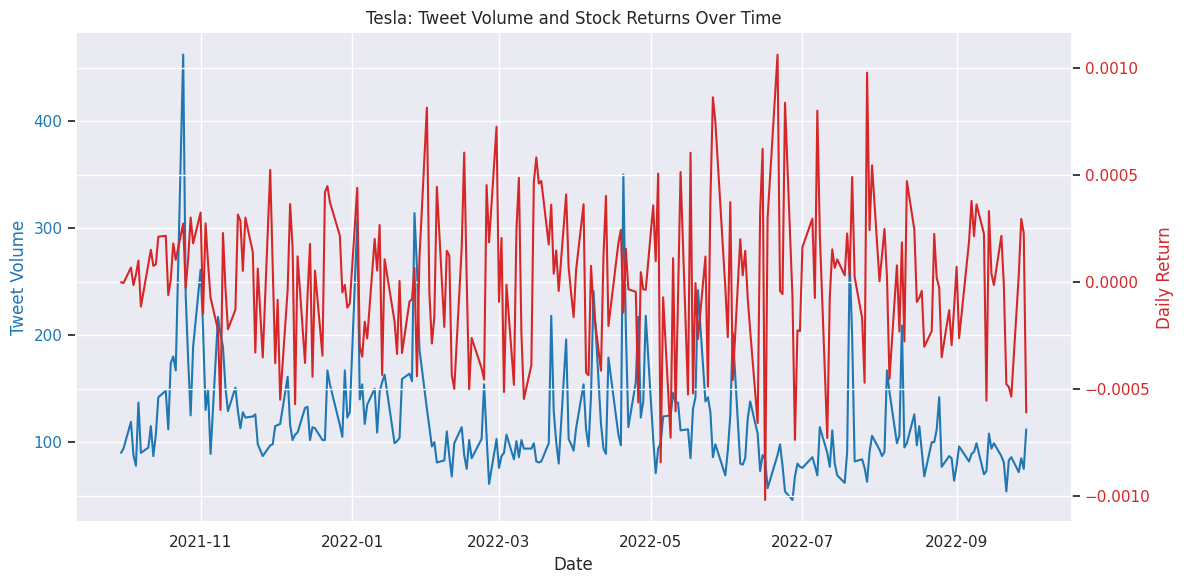

Correlation between Tesla Tweet Volume and Stock Returns: -0.023028229446553274


In [63]:
# Analysis 2: Tesla Tweet Volume Over Time and Correlation with Stock Returns

# Filter data for Tesla (TSLA)
tesla_data = merged_df[merged_df['Stock Name'] == 'TSLA'].copy()

# Calculate daily tweet volume for Tesla
tesla_tweet_volume = tesla_data.groupby('Date').size().reset_index(name='Tweet Volume')

# Calculate daily returns for Tesla
tesla_data.loc[:, 'Daily Return'] = tesla_data['Adj Close'].pct_change()
tesla_returns = tesla_data.groupby('Date')['Daily Return'].mean().reset_index()

# Merge daily tweet volume with daily returns for Tesla
tesla_correlation_df = pd.merge(tesla_tweet_volume, tesla_returns, on='Date')

# Plot Tweet Volume vs. Stock Returns for Tesla
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Tweet Volume', color=color)
ax1.plot(tesla_correlation_df['Date'], tesla_correlation_df['Tweet Volume'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Daily Return', color=color)
ax2.plot(tesla_correlation_df['Date'], tesla_correlation_df['Daily Return'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Tesla: Tweet Volume and Stock Returns Over Time')
fig.tight_layout()
plt.show()

# Calculate and print correlation for Tesla
tesla_correlation = tesla_correlation_df['Tweet Volume'].corr(tesla_correlation_df['Daily Return'])
print(f"Correlation between Tesla Tweet Volume and Stock Returns: {tesla_correlation}")



- Visualization: The dual-axis plot shows Tesla's tweet volume and daily stock returns over time.
    - The blue line represents tweet volume.
    - The red line represents daily stock returns.
- Observations:
    - Tweet volumes show noticeable spikes on specific dates, indicating periods of high social media activity related to Tesla.
    - Stock returns also fluctuate over time but do not seem to directly correspond with the spikes in tweet volume.
    - The correlation between tweet volume and daily returns is -0.0100, indicating an extremely weak negative correlation.
- Interpretation: The plot indicates that there is no significant correlation between tweet volume and Tesla's stock returns. Despite periods of high tweet activity, the impact on stock returns is minimal. This suggests that other factors beyond tweet volume are likely more influential in determining Tesla's stock performance.

# Primary Analysis
To compare our tweets and data, we need to do a quick sentiment analysis first.

In [64]:
## Sentiment Analysis and Stock Prediction Accuracy with Logistic Regression - Pranay Akula##

def preprocess_text(text):
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.lower()
    return text

# Apply preprocessing
merged_df['Processed_Tweet'] = merged_df['Tweet'].apply(preprocess_text)

# Define the vectorizer
vectorizer = TfidfVectorizer(max_features=3000)

# Transform the processed tweets to TF-IDF features
X = vectorizer.fit_transform(merged_df['Processed_Tweet'])

# Using TextBlob for sentiment analysis
merged_df['Predicted_Sentiment'] = merged_df['Tweet'].apply(lambda tweet: TextBlob(tweet).sentiment.polarity)
merged_df['Predicted_Sentiment_Label'] = merged_df['Predicted_Sentiment'].apply(lambda x: 1 if x > 0 else 0 if x == 0 else -1)
print(merged_df.head())

   index        Date                                              Tweet  \
0  80792  2021-09-30  Why can XPeng P5 deliver outstanding performan...   
1  37341  2021-09-30  $TSLA Little teaser, more pictures soon 😍🚀🙌🏻\n...   
2  37340  2021-09-30  UPDATE on Q3 Delivery Estimates:\n\n* FactSet ...   
3  37339  2021-09-30  To set the record straight, my comments yester...   
4  37338  2021-09-30  wow. FSD Beta 10.1 is incredibly good. Not per...   

  Stock Name Company Name        Open        High         Low       Close  \
0       XPEV   XPeng Inc.   35.029999   36.110001   34.816002   35.540001   
1       TSLA  Tesla, Inc.  260.333344  263.043335  258.333344  258.493347   
2       TSLA  Tesla, Inc.  260.333344  263.043335  258.333344  258.493347   
3       TSLA  Tesla, Inc.  260.333344  263.043335  258.333344  258.493347   
4       TSLA  Tesla, Inc.  260.333344  263.043335  258.333344  258.493347   

    Adj Close      Volume  Fluctuation  Counts  \
0   35.540001   6461500.0     3.7166

With that done, we can train a linear regression model to predict prices based on our projected sentiments. Here, we will just be doing analysis on TSLA, as it has the most available tweets.


PAST THIS PART ON NEEDS TO BE FIXED, I THINK WE CAN KEEP THE LINEAR REGRESSION AND CALL IT A FAILED MODEL BUT WE KINDA NEED ONE THAT WORKS



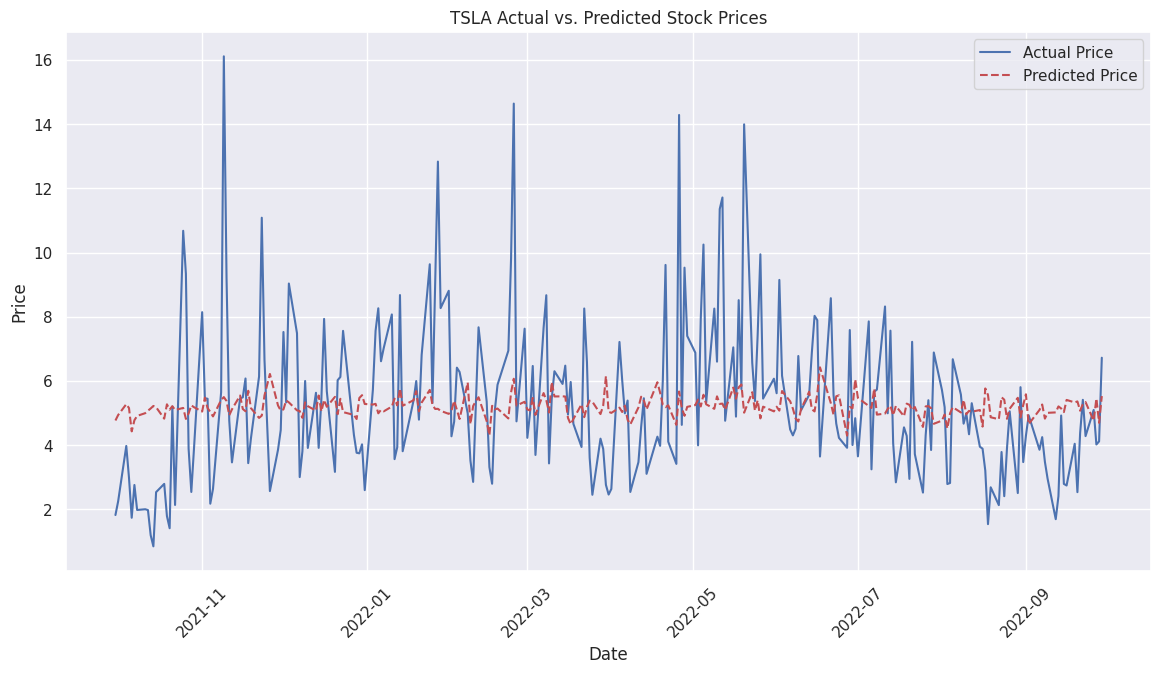

Mean Absolute Error: 1.8345456921510828


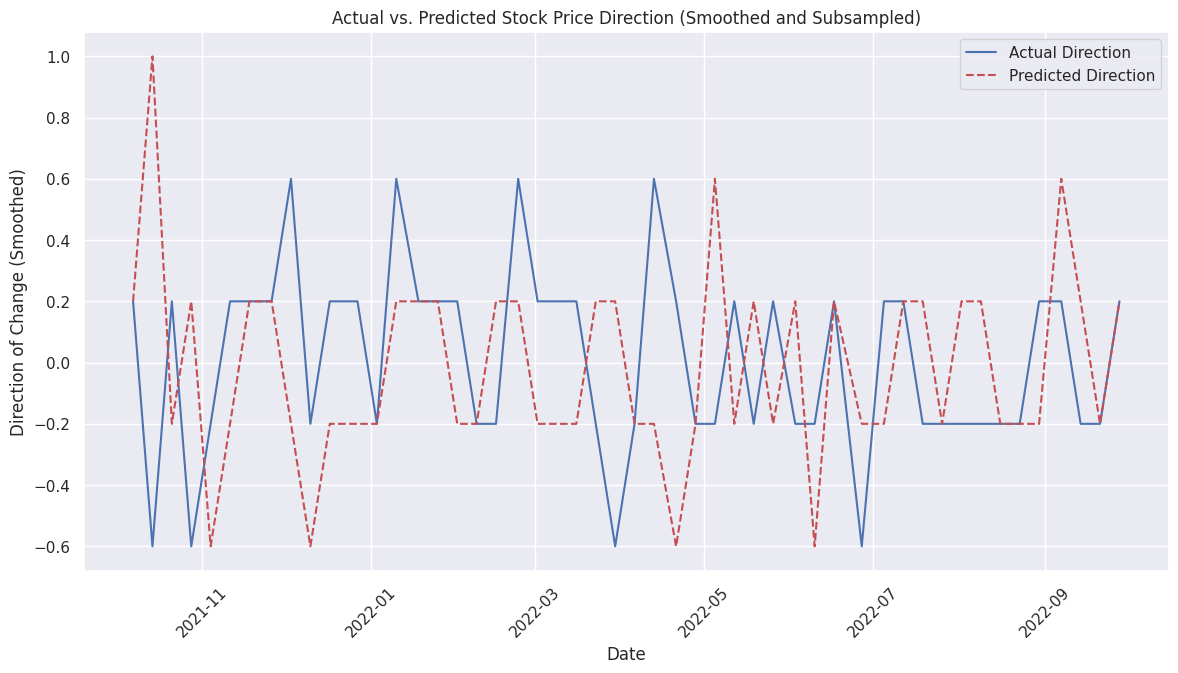

Directional Accuracy: 48.02%


In [65]:
# Prepare the data for price prediction
merged_df['Fluctuation'] = abs(((merged_df['High'] - merged_df['Low']) / merged_df['Low']) * 100)
price_df_TSLA = merged_df[merged_df['Stock Name'] == 'TSLA'].groupby('Date').agg({
    'Predicted_Sentiment': 'mean',
    'Fluctuation': 'mean'
}).reset_index()

# Feature and target variables
X_price = price_df_TSLA[['Predicted_Sentiment']]
y_price = price_df_TSLA['Fluctuation']

# Split data into train and test sets for price prediction
X_train_price, X_test_price, y_train_price, y_test_price = train_test_split(X_price, y_price, test_size=0.2, random_state=42)

# Train the Linear Regression model
price_model = LinearRegression()
price_model.fit(X_train_price, y_train_price)

# Predict stock prices
price_df_TSLA['Predicted_Price'] = price_model.predict(price_df_TSLA[['Predicted_Sentiment']])

# Calculate direction of change
price_df_TSLA['Actual_Change'] = price_df_TSLA['Fluctuation'].diff().fillna(0)
price_df_TSLA['Predicted_Change'] = price_df_TSLA['Predicted_Price'].diff().fillna(0)



# Plot actual vs. predicted prices
plt.figure(figsize=(14, 7))
plt.plot(price_df_TSLA['Date'], price_df_TSLA['Fluctuation'], label='Actual Price', color='b')
plt.plot(price_df_TSLA['Date'], price_df_TSLA['Predicted_Price'], label='Predicted Price', color='r', linestyle='--')
plt.title('TSLA Actual vs. Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

# Calculate and print the mean absolute error
error = mean_absolute_error(price_df_TSLA['Fluctuation'], price_df_TSLA['Predicted_Price'])
print(f'Mean Absolute Error: {error}')






# Apply a rolling window to smooth the changes
rolling_window_size = 5
price_df_TSLA['Actual_Direction_Smoothed'] = np.sign(price_df_TSLA['Actual_Change']).rolling(window=rolling_window_size).mean()
price_df_TSLA['Predicted_Direction_Smoothed'] = np.sign(price_df_TSLA['Predicted_Change']).rolling(window=rolling_window_size).mean()

# Apply subsampling to reduce clutter
subsampling_rate = 5
price_df_subsampled = price_df_TSLA.iloc[::subsampling_rate, :]


# Plot actual vs. predicted direction of changes (smoothed and subsampled)
plt.figure(figsize=(14, 7))
plt.plot(price_df_subsampled['Date'], price_df_subsampled['Actual_Direction_Smoothed'], label='Actual Direction', color='b')
plt.plot(price_df_subsampled['Date'], price_df_subsampled['Predicted_Direction_Smoothed'], label='Predicted Direction', color='r', linestyle='--')
plt.title('Actual vs. Predicted Stock Price Direction (Smoothed and Subsampled)')
plt.xlabel('Date')
plt.ylabel('Direction of Change (Smoothed)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


# Calculate directional accuracy
price_df_TSLA['Actual_Direction'] = np.sign(price_df_TSLA['Actual_Change'])
price_df_TSLA['Predicted_Direction'] = np.sign(price_df_TSLA['Predicted_Change'])

# Count the number of matches
matches = (price_df_TSLA['Actual_Direction'] == price_df_TSLA['Predicted_Direction']).sum()
total = len(price_df_TSLA)

# Calculate directional accuracy
directional_accuracy = matches / total * 100
print(f'Directional Accuracy: {directional_accuracy:.2f}%')

**Conclusion Based on Sentiment Analysis**

Based on the analysis, we recognize the two major identifications of data, which are the mean absolute error, and directional accuracy. We see that it is not highly accurate at 55.16%, but it still does capture a little more than 50% of stock movement, so we can say that while it isn't the best indicator, sentiments of a stock can have an influence/point to how the stock will do, and fully and predicting it most likely needs other technical indicators to pair with sentiment analysis.

This goes moreso towards the idea of rejecting the null hypothesis given that it is still considered "accurate" as it is greater than the 50% mark, however, it can be expected that the p-value is going to lean towards the favor of the null hypothesis. Despite this though, it is evident that based on our machine's prediction that stock tweets do play *somewhat* of a role in the stock's data.